# Section X:  Generating Noise Simulations with DR4 split data.  

This Section will generate a set of simulated noise maps necessary for building power spectra convariance matrices, calculating transfer functions, and performing consistency checks. In particular, we step through the noise map prescription available in the appendix of [Choi et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=choi_etal_2020.pdf). For simplicity, we consider only one season/patch/array/freq combination (s15/D56/PA1/150 GHz), while in reality the full pipeline performs an analogous process for all such data sets.

To return to the main notebook or to view a different section use the links in the table of contents.


## Table of contents

 --- 
> [Section 1](Section_1_Advanced_ACT_DR4_Combined_data_products.ipynb): Introduction and Importing Pixell, Healpy and other key packages

> [Section 2](Section_2_coadded_maps.ipynb): S08-18 Coadded maps and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to converted maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps.

> [Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps.

> [Section 7](Section_7_harmonic_analysis.ipynb):  Harmonic Analysis with CAR Maps

> [Section 8](Section_8_power_spectrum.ipynb): Maps and Power Spectra of Individual Patches 

> [Section 9](Section_9_E_B_maps.ipynb):  Looks at how to generate E and B maps from I, Q, U maps. 

---

## Part 1: Import and Prepare the Data

As before, we begin by running the first notebook to import necessary packages and define the data path. Then we redefine our plotting convencience function and some handy plotting keywords to pass to enplot.plot.

In [1]:
%run Section_1_Advanced_ACT_DR4_Combined_data_products.ipynb

def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

map_kwargs = dict(downgrade = 8, ticks = 25, colorbar = True)
fourier_kwargs = dict(downgrade = 8, ticks = -1, colorbar = True)

The noise prescription utilizes "splits" of the data, which are maps generated from non-overlapping, interleaved slices of the full TOD. Each dataset (season/patch/array/frequency) has 4 splits with the exception of the AA patch, which has 2. We release maps of all splits, as well as the coadded maps for each dataset, in DR4 (see [Aiola et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=ACT_DR4_A20_v20200420.pdf), Table 2). 

Let's load the set of (4) splits for s15/D56/PA1/150 GHz, as well as the coadded map. We also load the apodized boundary window for the maps, which is common to every dataset within a given patch. The procedure for generating this boundary window is detailed in [Choi et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=choi_etal_2020.pdf).

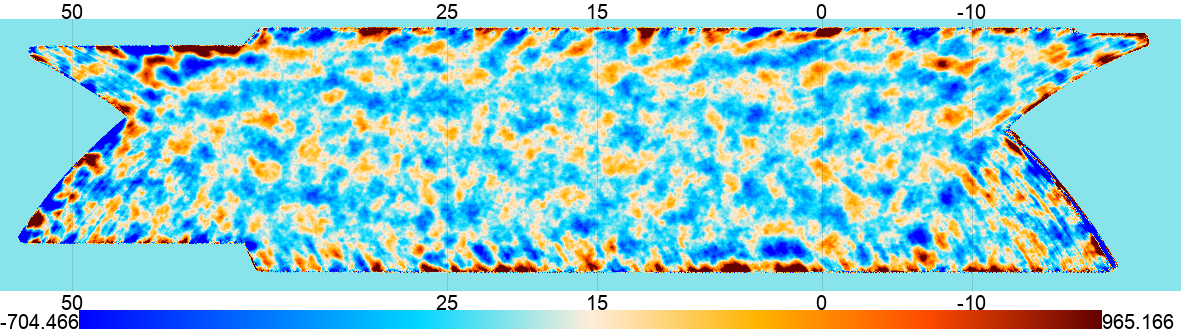

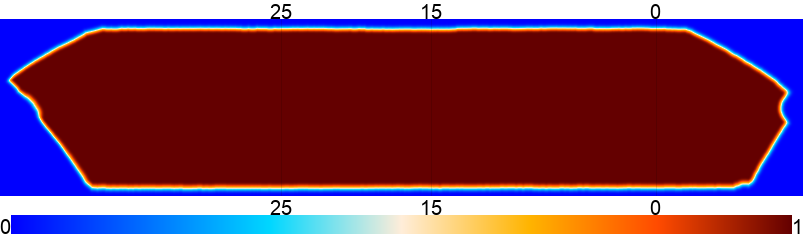

In [2]:
# Load the map-based splits and their coadd for the s15/D56/PA1 data set
splits = [enmap.read_map(path + f'act_dr4_s15_D56_pa1_f150_nohwp_night_3pass_4way_set{i}_map_srcfree.fits') for i in range(4)]
coadd = enmap.read_map(path + 'act_dr4_s15_D56_pa1_f150_nohwp_night_3pass_4way_coadd_map_srcfree.fits')

# Load the common boundary window for D56
window = enmap.read_map(path + 'act_dr4_D56_apo_w0.fits')

# Plot the first split I map and the window
eshow(splits[0][0], **map_kwargs)
eshow(window, **map_kwargs)

In general, the boundary window map has a smaller overall extent than the data maps, so we must use the enmap.extract function to ensure all our data products have the same shape and wcs.

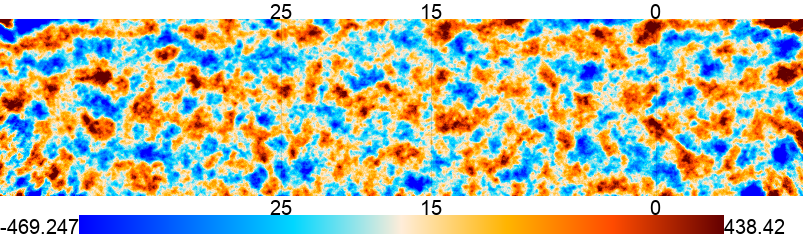

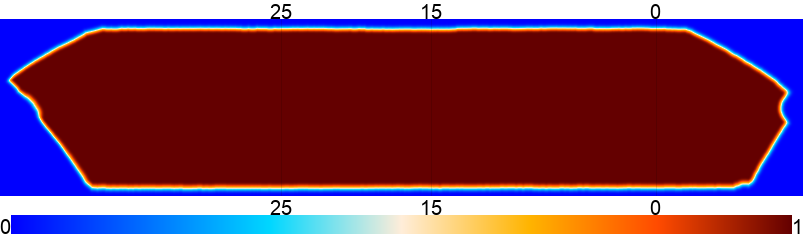

In [3]:
# Slice the splits and coadd map to ensure they align with the window
s_splits = enmap.samewcs([enmap.extract(splits[i], window.shape, window.wcs) for i in range(4)], window)
s_coadd = enmap.extract(coadd, window.shape, window.wcs)

# Plot the first split I map and the window
eshow(s_splits[0][0], **map_kwargs)
eshow(window, **map_kwargs)

The noise prescription also requires the inverse-variance maps corresponding to the splits and the coadded map (see Table 1 of [Section 1](Section_1_Advanced_ACT_DR4_Combined_data_products.ipynb)). Again, we use the enmap.extract function, referenced to the common boundary window, to regularize the shape and wcs of the inverse-variance maps.

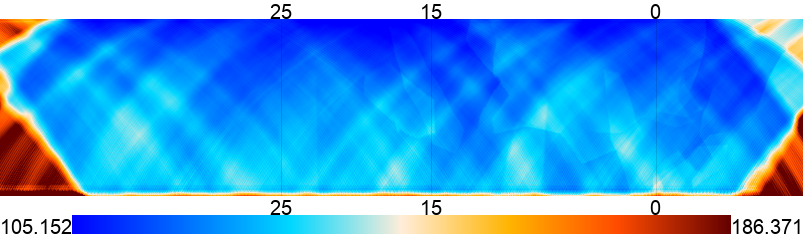

In [4]:
# Load the inverse-variance maps for the splits and for the coadd map
ivar_splits = [enmap.read_map(path + f'act_dr4_s15_D56_pa1_f150_nohwp_night_3pass_4way_set{i}_ivar.fits') for i in range(4)]
ivar_coadd = enmap.read_map(path + 'act_dr4_s15_D56_pa1_f150_nohwp_night_3pass_4way_coadd_ivar.fits')

# Slice the inverse-variance maps to ensure they align with the window
s_ivar_splits = enmap.samewcs([enmap.extract(ivar_splits[i], window.shape, window.wcs) for i in range(4)], window)
s_ivar_coadd = enmap.extract(ivar_coadd, window.shape, window.wcs)

# Plot the first split r.m.s. error map
eshow(1/np.sqrt(s_ivar_splits[0]), **map_kwargs)

Although in principle the inverse-variance maps contain the I, Q, U matrix elements at every pixel, as noted in [Aiola et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=ACT_DR4_A20_v20200420.pdf) we find that the matrices are well approximated by the large-hit-count, well-cross-linked limit. That is, the off diagonal covariance elements are ~0, and the Q, U *r.m.s error* elements are each ~sqrt(2) *larger* than the intensity *r.m.s. error*. Therefore, in DR4 we release only the intensity *inverse-variance* map for each split and coadd, which contains all the map-based inverse-variance information.

For this exercise we therefore need to reconstruct the polarization inverse-variance maps. 

In [5]:
def make_IQU_ivars(ivars):
    '''Copy the inverse-variance I map into I, Q, U array'''
    ndims = len(ivars.shape)

    # I, Q, U axis in pixell is always the 3rd from the right
    expand_ivars = np.expand_dims(ivars, axis = -3)

    # We need 3 copies of the existing map along the I, Q, U axis 
    reps = np.ones(ndims+1, dtype = int)
    reps[-3] = 3

    # Copy the map and divide the Q, U inverse-variance by 2
    copy_ivars = np.tile(expand_ivars, reps)
    copy_ivars[..., 1:, :, :] /= np.sqrt(2)

    return enmap.samewcs(copy_ivars, ivars)

# Get the IQU inverse-variance maps for each split and for the coadd map
s_ivarIQU_splits = make_IQU_ivars(s_ivar_splits)
s_ivarIQU_coadd = make_IQU_ivars(s_ivar_coadd)

A quick sanity-check:

In [6]:
# For clarity the shape and wcs of everything matches up correctly
print('Splits')
print('Maps:', s_splits.shape, s_splits.wcs)
print('Ivars:', s_ivarIQU_splits.shape, s_ivarIQU_splits.wcs, '\n')
print('Coadds')
print('Maps:', s_coadd.shape, s_coadd.wcs)
print('Ivars:', s_ivarIQU_coadd.shape, s_ivarIQU_coadd.wcs, '\n')
print('Window')
print(window.shape, window.wcs)

Splits
Maps: (4, 3, 1416, 6426) car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397,906]}
Ivars: (4, 3, 1416, 6426) car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397,906]} 

Coadds
Maps: (3, 1416, 6426) car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397,906]}
Ivars: (3, 1416, 6426) car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397,906]} 

Window
(1416, 6426) car:{cdelt:[-0.008333,0.008333],crval:[15.47,0],crpix:[3397,906]}


## Part 2: Generate Noise Power Spectra

The noise prescription takes the difference between each split map and the coadd to be an estimate of the pure noise in the data. We'll refer to these differences as "null" maps, but just to be clear, they are formally a map of the difference between the *realization* of the split-map noise and the *realization* of the coadd map noise.

In general, we expect to visually see a lot of low-frequency atmospheric noise:

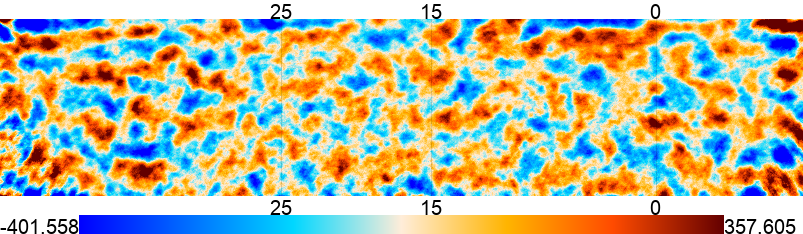

In [35]:
# Subtract the coadd map from each split map
d = s_splits - s_coadd

# Plot the first split I null map
eshow(d[0, 0], **map_kwargs)

As an aside, we can directly check the definition of the coadd map given in [Choi et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=choi_etal_2020.pdf) -- the inverse-variance-weighted sum of the split maps. Comparing this quantity to the DR4-provided coadd map shows the two are in exceptional agreement for each of I, Q, U:

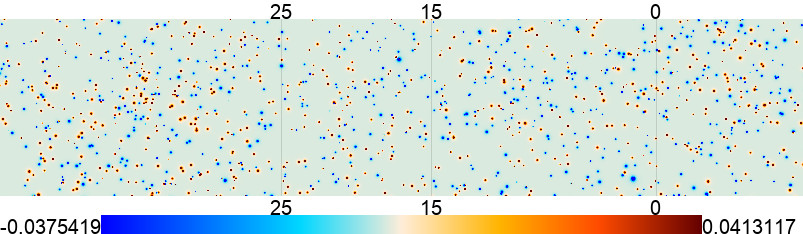

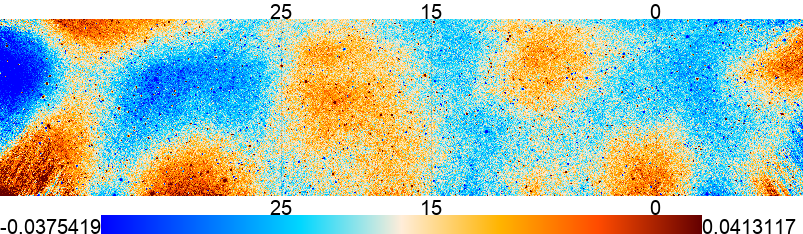

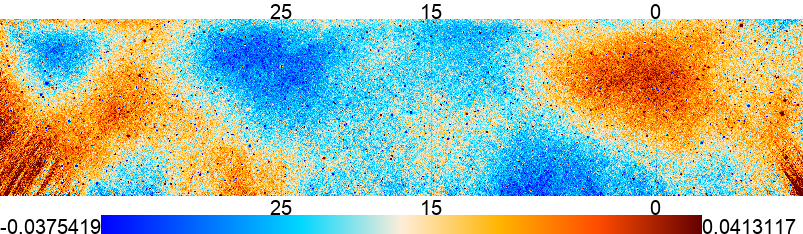

In [8]:
def make_coadd(maps, ivars):
    '''Get the coadded map from a set of split maps and their inverse-variances'''
    c = np.sum(maps * ivars, axis = 0)
    c /= np.sum(ivars, axis = 0)
    return enmap.samewcs(c, maps)

# The constructed coadd map
c = make_coadd(s_splits, s_ivarIQU_splits)

# Compare to the DR4 coadd map
eshow(c - s_coadd, **map_kwargs)


Note the colorbar is in units of $\mu K_{cmb}$, so the errors are negligible compared to the CMB anisotropy. For completeness, we use the DR4-provided coadd map in the rest of this notebook.

Anywho, back to noise sims! Our goal will be to analyze and apply the frequency content of the null maps. Before taking any Fourier transforms, we need to apply both our window and a "flattening" weight map to the null maps. The flattening weight is defined as the inverse *r.m.s. error* of the null maps. Based on the definition of the null map above, this turns out to be given by the below (work it out for yourself!):


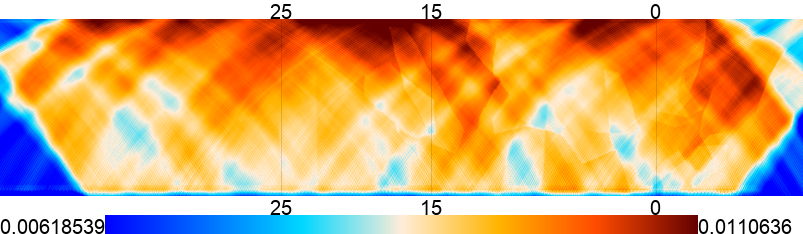

In [36]:
def make_flattening_weight(ivarIQU_splits, ivar_coadd):
    '''The inverse-rms-error for the null maps'''
    return enmap.samewcs(1/np.sqrt(1/ivarIQU_splits - 1/ivar_coadd), ivar_coadd)

# Get the flattening weights for our null maps
flattening_weight = make_flattening_weight(s_ivarIQU_splits, s_ivarIQU_coadd)

# Plot the flattening weight for the first split I map
eshow(flattening_weight[0, 0], **map_kwargs)

Now we examine the 2D power spectrum of the window-weighted, flattening-weighted null maps.

In [10]:
k_d = enmap.fft(window * flattening_weight * d, normalize = 'phys')

Because the null maps contain an *independent* realizations of the split-map noise and the *same* realization of the coadd-map noise, we define the power spectrum estimator as the following average:

In [28]:
def get_power(k_maps, a, b, window):
    '''The 2D power spectrum for a set of fourier null maps

    a: 0, 1, or 2 for I, Q, U
    b: 0, 1, or 2 for I, Q, U
    window: apodized boundary window for the patch'''
    n = len(k_maps)
    assert n == 4

    # Extract I, Q, U components    
    ka_map = k_maps[:, a]
    kb_map = k_maps[:, b]

    # Get squared apodization
    w2 = np.mean(window**2)

    # Note the denominator is n*(n-1)
    power = 1/n/(n-1) * enmap.samewcs(np.sum(ka_map * np.conj(kb_map), axis = 0), ka_map)
    return power / w2

Let's check out our 2D power spectra! We have 6 independent spectra from all the polarization combinations:

0 0


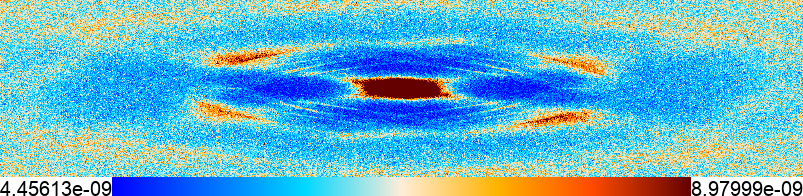

0 1


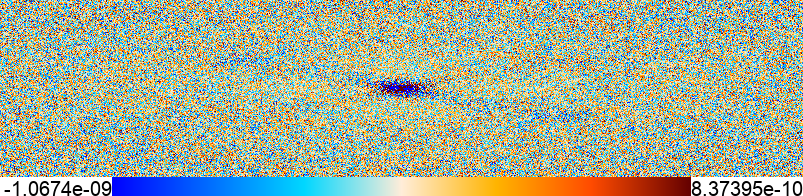

0 2


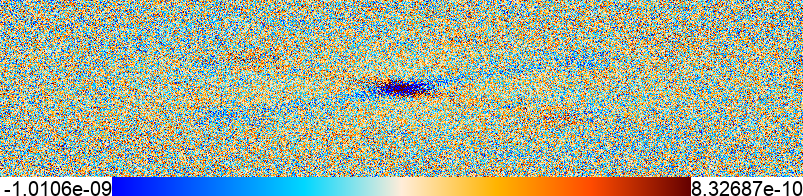

1 1


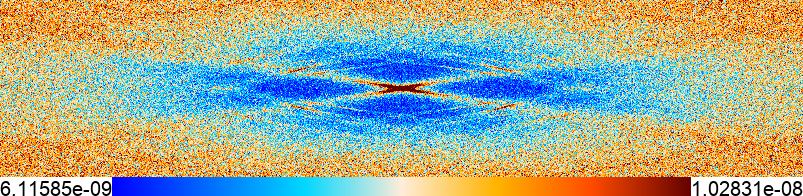

1 2


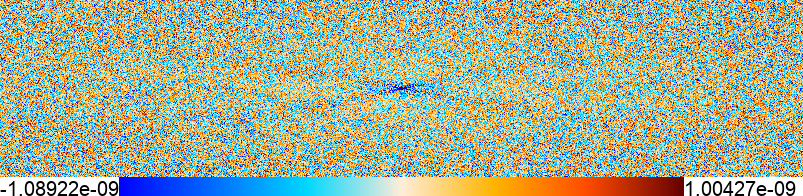

2 2


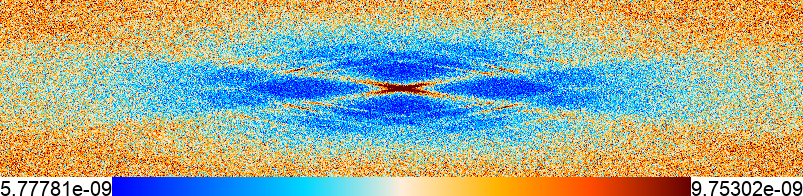

In [21]:
for i in range(3): 
    for j in range(i, 3):
        print(i, j)
        p = np.real(get_power(k_d, i, j, window))
        eshow(enmap.fftshift(p), **fourier_kwargs)

As is explained in the text of [Choi et al. (2020)](https://phy-wiki.princeton.edu/polwiki/pmwiki.php?n=Papers.Papers?action=download&upname=choi_etal_2020.pdf), the 2D power spectra are not isotropic. However, we will at least assume that the above "noise" spectra are the same at all (real-space) points within the map, up to overall magnitude. 

We can learn a bit more by azimuthally binning the noise spectra and examining only their $l$ dependence:

In [23]:
def bin(data, imap, lmax, bin_size):
    modlmap = imap.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    binned = np.bincount(digitized, data.reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    return centers, binned

First the cross-spectra:

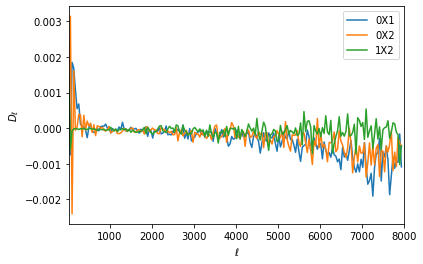

In [26]:
for i in range(3):
    for j in range(i, 3):
        if i == j: continue
        cents, bells = bin(np.real(get_power(k_d, i, j, window)), k_d, 8000, 40)
        plt.plot(cents, bells*cents**2./2./np.pi, label=f"{i}X{j}")
plt.legend()
plt.xlim(30, 8000)
plt.xlabel("$\\ell$")
plt.ylabel("$D_{\\ell}$")
plt.xscale('linear')
plt.yscale('linear')

Then, the auto-spectra:

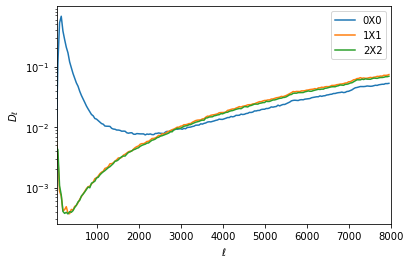

In [27]:
for i in range(3):
    for j in range(i, 3):
        if i != j: continue
        cents, bells = bin(np.real(get_power(k_d, i, j, window)), k_d, 8000, 40)
        plt.plot(cents, bells*cents**2./2./np.pi, label=f"{i}X{j}")
plt.legend()
plt.xlim(30, 8000)
plt.xlabel("$\\ell$")
plt.ylabel("$D_{\\ell}$")
plt.xscale('linear')
plt.yscale('log')

We have recovered the two primary features of the noise spectra! That is, at low $l$, there is the expected atmospheric 1/f contribution. At large $l$, the noise hits a white-noise floor (in $D_{l}$ space white-noise rises as ~$l^2$).